elapsed time: 15.782388600055128


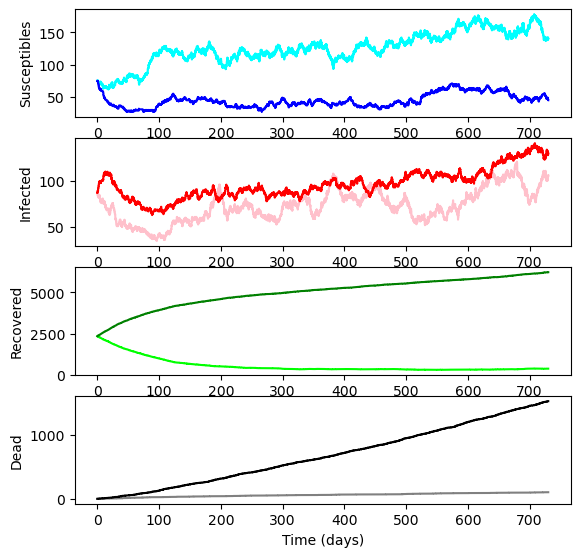

<Figure size 2560x2560 with 0 Axes>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from numba import jit
from matplotlib.pyplot import figure

Number_Age_Classes = 2

#alpha is the rate at which members of our population age up from young to old
alpha = 0.01
#beta is the infection rate. First input is for the young, second for the old. This is the same for most of these factors
beta = np.array((1, 1))
#gamma is the recovery rate
gamma = np.array((1/25, 1/50))
#mu is the death rate. Rows represent each infection state, while columns represent age
mu = np.array([[1e-4, 2e-4], [4e-4, 8e-4], [2e-4, 4e-4]])
birth_rate = 0.001
N0 = np.array([4000, 1000])
ND = MaxTime = 2 * 365
I0 = [np.ceil((np.sum(mu) * np.sum(N0)) / (np.sum(gamma) * 2)), np.floor((np.sum(mu) * np.sum(N0)) / (np.sum(gamma) * 2))]
S0 = [np.ceil((np.sum(gamma) * np.sum(N0)) / (np.sum(beta) * 2)), np.floor((np.sum(gamma) * np.sum(N0)) / (np.sum(beta) * 2))]
R0 = [np.ceil((np.sum(N0) - (np.sum(S0) + np.sum(I0)))/2), np.floor((np.sum(N0) - (np.sum(S0) + np.sum(I0)))/2)]
D0 = [0, 0]

INPUT = [S0,I0,R0,D0]
timestep=0.0

@jit(nopython=True)
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

def Stochastic_equations(INP,ts): 
    Rate = np.zeros((9))
    SubRate = np.zeros((9, 4))
    #9 is the number of rules, 4 the max number of subrules, 4 the number of infection states
    Pop_Change = np.zeros((9, 4, 4, Number_Age_Classes))
    N = np.sum(INP[0]+INP[1]+INP[2])
    #rule 1: S to S (susceptible ageing)
    #subrule 1: Y to O
    SubRate[0, 0] = alpha * INP[0][0]
    Pop_Change[0, 0,:] = np.array([[-1,+1], [0,0], [0,0], [0,0]])
    #rule 2: I+S to I+I (infection)
    #subrule 1: Y+Y (young infected by young)
    SubRate[1, 0] = (beta[0]**2) * INP[0][0] * INP[1][0] / N
    Pop_Change[1, 0,:] = np.array([[-1,0], [+1,0], [0,0], [0,0]])
    #subrule 2: O+Y (young infected by old)
    SubRate[1, 1] = (beta[0]*beta[1]) * INP[1][1] * INP[0][0] / N
    Pop_Change[1, 1,:] = np.array([[-1,0], [+1,0], [0,0], [0,0]])
    #subrule 3: Y+O (old infected by young)
    SubRate[1, 2] = (beta[0]*beta[1]) * INP[0][1] * INP[1][0] / N
    Pop_Change[1, 2,:] = np.array([[0,-1], [0,+1], [0,0], [0,0]])
    #subrule 4: O+O (old infected by old)
    SubRate[1, 3] = (beta[1]**2) * INP[0][1] * INP[1][1] / N
    Pop_Change[1, 3,:] = np.array([[0,-1], [0,+1], [0,0], [0,0]])
    #rule 3: S to D (susceptible death)
    #subrule 1: Y
    SubRate[2, 0] = mu[0][0] * INP[0][0]
    Pop_Change[2, 0,:] = np.array([[-1,0], [0,0], [0,0], [+1,0]])
    #subrule 2: O
    SubRate[2, 1] = mu[0][1] * INP[0][1]
    Pop_Change[2, 1,:] = np.array([[0,-1], [0,0], [0,0], [0,+1]])
    #rule 4: I to I (infected ageing)
    #subrule 1: Y to O
    SubRate[3, 0] = alpha * INP[1][0]
    Pop_Change[3, 0,:] = np.array([[0,0], [-1,+1], [0,0], [0,0]])
    #rule 5: I to R (infected recovery)
    #subrule 1: Y
    SubRate[4, 0] = gamma[0] * INP[1][0]
    Pop_Change[4, 0,:] = np.array([[0,0], [-1,0], [+1,0], [0,0]])
    #subrule 2: O
    SubRate[4, 1] = gamma[1] * INP[1][1]
    Pop_Change[4, 1,:] = np.array([[0,0], [0,-1], [0,+1], [0,0]])
    #rule 6: I to D (infected death)
    #subrule 1: Y
    SubRate[5, 0] = mu[1][0] * INP[1][0]
    Pop_Change[5, 0,:] = np.array([[0,0], [-1,0], [0,0], [+1,0]])
    #subrule 2: O
    SubRate[5, 1] = mu[1][1] * INP[1][1]
    Pop_Change[5, 1,:] = np.array([[0,0], [0,-1], [0,0], [0,+1]])
    #rule 7: R to R (recovered ageing)
    #subrule 1; Y to O
    SubRate[6, 0] = alpha * INP[2][0]
    Pop_Change[6, 0,:] = np.array([[0,0], [0,0], [-1,+1], [0,0]])
    #rule 8: R to D (recovered death)
    #subrule 1: Y
    SubRate[7, 0] = mu[2][0] * INP[2][0]
    Pop_Change[7, 0,:] = np.array([[0,0], [0,0], [-1,0], [+1,0]])
    #subrule 2: O
    SubRate[7, 1] = mu[2][1] * INP[2][1]
    Pop_Change[7, 1,:] = np.array([[0,0], [0,0], [0,-1], [0,+1]])
    #rule 9: Birth: 
    #subrule 1:
    SubRate[8, 0] = birth_rate * (INP[0]+INP[1]+INP[2])[1]
    Pop_Change[8, 0,:] = np.array([[+1,0], [0,0], [0,0], [0,0]])
    for i in range(len(Rate)):
        Rate[i] = np.sum(SubRate[i])
    r1 = np.random.rand() 
    r2 = np.random.rand()
    ts = -np.log(r1) / (np.sum(Rate));
    #decides what equation to use
    m1 = min(find(np.cumsum(Rate) >= np.sum(Rate) * r2));
    r2 = r2 - (np.cumsum(Rate)[m1-1]/np.sum(Rate))
    m2 = min(find(np.cumsum(SubRate[m1]) >= np.sum(Rate) * r2));
    INP += Pop_Change[m1, m2, :]
    return [INP,ts]

def Stochastic_iteration(INPUT):
    counter = 0
    ts = 0
    T = np.array([0])
    S = np.array([[0, 0]])
    I = np.array([[0, 0]])
    R = np.array([[0, 0]])
    D = np.array([[0, 0]])
    while T[counter] < ND:
        counter+=1
        #print(INPUT)
        T = np.concatenate((T, np.array([T[counter-1]+ts])))
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1]])))
        R = np.concatenate((R, np.array([INPUT[2]])))
        D = np.concatenate((D, np.array([INPUT[3]])))
        [INPUT,ts] = Stochastic_equations(INPUT,ts)
        counter+=1
        #print(INPUT)
        T = np.concatenate((T, np.array([T[counter-1]])))
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1]])))
        R = np.concatenate((R, np.array([INPUT[2]])))
        D = np.concatenate((D, np.array([INPUT[3]])))
    return [T,S,I,R,D]

start = timer()
[T,S,I,R,D]=Stochastic_iteration(INPUT)
end = timer()

print(f'elapsed time: {end - start}')


tT=np.array(T)[1:,]
tS=np.array(S)[1:,]
tI=np.array(I)[1:,]
tR=np.array(R)[1:,]
tD=np.array(D)[1:,]

plt.subplot(4, 1, 1)
plt.plot(tT, tS[:,0],'cyan')
plt.plot(tT, tS[:,1],'blue')
plt.ylabel ('Susceptibles')
plt.subplot(4, 1, 2)
plt.plot(tT, tI[:,0], 'pink')
plt.plot(tT, tI[:,1], 'red')
plt.ylabel ('Infected')
plt.subplot(4, 1, 3)
plt.plot(tT, tR[:,0], 'lime')
plt.plot(tT, tR[:,1], 'green')
plt.ylabel ('Recovered')
plt.subplot(4, 1, 4)
plt.plot(tT, tD[:,0], 'grey')
plt.plot(tT, tD[:,1], 'black')
plt.ylabel ('Dead')
plt.xlabel ('Time (days)')
plt.gcf().subplots_adjust(bottom=-0.15)
figure(figsize=(16, 16), dpi=160)
plt.show()

In [2]:
#below is a diagnostic tool to work out if we have issues with negative population. this belongs in the stochastic equation function
    if -1 in INP:
        print("r1 and r2", r1, r2)
        print("and our initial r2 was", r2 + np.cumsum(Rate)[m1-1])
        print("scaled this was", (r2 + np.cumsum(Rate)[m1-1]) * np.sum(Rate))
        print("m1 and m2", m1, m2)
        print(gamma[0] * INP[1][0])
        print("Rate", Rate)
        print("SubRate", SubRate[m1])
        print("Cumsum rate", np.cumsum(Rate))
        print("CumSum subrate", np.cumsum(SubRate[m1]))
        print(Pop_Change[m1, m2, :])

IndentationError: unexpected indent (979037231.py, line 2)